# **Get WildPPG example dataset**

In [2]:
from scipy.io import loadmat
import numpy as np

file = loadmat('../data/raw/WildPPG_Part_an0.mat', squeeze_me=True, struct_as_record=False) #Adjust path as needed

ppg_wrist_g  = file['wrist'].ppg_g.v
ppg_wrist_r  = file['wrist'].ppg_r.v
ppg_wrist_ir = file['wrist'].ppg_ir.v
ppg_fs       = file['wrist'].ppg_g.fs

acc_wrist_x = file['wrist'].acc_x.v
acc_wrist_y = file['wrist'].acc_y.v
acc_wrist_z = file['wrist'].acc_z.v
acc_wrist_fs = file['wrist'].acc_x.fs

delta_t = 1/ppg_fs
num_samples = len(ppg_wrist_g)
ppg_time = np.linspace(0, (num_samples-1)*delta_t, num_samples)
sample_seconds = 8

ppg_window_ir   = ppg_wrist_ir[:sample_seconds*ppg_fs]
acc_x_window = acc_wrist_x[:sample_seconds*acc_wrist_fs]
acc_y_window = acc_wrist_y[:sample_seconds*acc_wrist_fs]
acc_z_window = acc_wrist_z[:sample_seconds*acc_wrist_fs]
time_window  = ppg_time[:sample_seconds*ppg_fs]

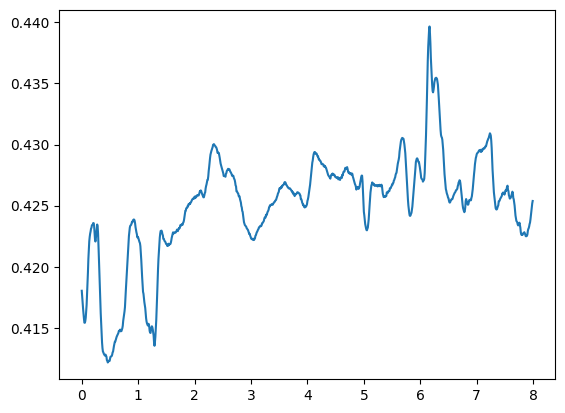

In [2]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(time_window, ppg_window_ir)
plt.show()

# **Check all classes**

In [3]:
from sqis.calculation.imu import IMUDetector
from sqis.calculation.indices import SQIcalc
from sqis.calculation.fiducials import getFiducials
import ast

imu = IMUDetector(sampling_rate = ppg_fs, motion_threshold=0.2)
sqi = SQIcalc(sampling_rate=ppg_fs)
fid = getFiducials(sampling_rate=ppg_fs)

bad_motion, imu_metrics = imu.check_motion(acc_x_window, acc_y_window, acc_z_window)
if bad_motion:
    print("ABSTAIN - motion too high")
else:
    fid_dict = fid.extract_fiducials(ppg_window_ir)
    peaks            = fid_dict["systolic_peaks"]

    if len(peaks) > 1:
        # ... process diastolic peaks ...
        sqi_metrics = sqi.get_all_sqi(ppg_window_ir, peaks)
        print(f"SQIs: {sqi_metrics}")
    else:
        print("Skipping SQIs: Not enough peaks detected.")
    diastolic_peaks  = fid_dict["diastolic_peaks"]
    dicrotic_notches = fid_dict["notches"]
    pulse_onsets     = fid_dict["pulse_onsets"]
    
    
    

ABSTAIN - motion too high


In [4]:
from sqis.calculation.fiducials import getFiducials
from sqis.calculation.imu import IMUDetector
from sqis.calculation.indices import SQIcalc
from sqis.calculation.decision_policies import SignalStatus, Decision

imu = IMUDetector(sampling_rate=ppg_fs, motion_threshold=0.2)
fids = getFiducials(sampling_rate=ppg_fs)
sqis = SQIcalc(sampling_rate=ppg_fs)
decision_policy = Decision()

In [5]:
#Motion in imu
is_artifact, imu_metrics = imu.check_motion(acc_x_window, acc_y_window, acc_z_window)

#Fiducials
fids_dict = fids.extract_fiducials(ppg_window_ir)
peaks = fids_dict["systolic_peaks"]

if len(peaks) >= 3 and not is_artifact:
    sqi_metrics = sqis.get_all_sqi(ppg_window_ir, peaks)
else:
    sqi_metrics = {}

In [6]:
#Print out report

report = decision_policy.decide(sqi_metrics=sqi_metrics, motion_flagged=is_artifact, num_peaks=len(peaks))
print(f"\nSignal Status: {report.status.value}")
print(f"Confidence score: {report.confidence}")
if report.reasons:
    print(f"Reasons: {report.reasons}")


Signal Status: BAD
Confidence score: 0.0
Reasons: ['Critical Motion Exceeded']
